In [5]:
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from torchvision import datasets
import seaborn as sns
from matplotlib.colors import ListedColormap
sns.set()

In [8]:
# SMALL_SIZE = 8
# MEDIUM_SIZE = 10
# BIGGER_SIZE = 12

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# matplotlib.rc('xtick', labelsize=20) 
# matplotlib.rc('ytick', labelsize=20)

In [9]:
def get_mean_and_std(fpr_lists):
    fpr_all = []
    # fpr_all = np.empty(0, len(len(fpr_lists[0]) ))
    for fpr_list in fpr_lists:
        # print([*fpr_list.values()])
        fpr_all.append([fpr_list])
        # fpr_all = np.concatenate((fpr_all, ))
    fpr_all = np.array(fpr_all)
    # print(fpr_all)
    return fpr_all.mean(axis = 0).squeeze(), fpr_all.std(axis = 0).squeeze()

In [8]:
knn_fprs = {
    "sun": [0.76,22.04,45.92,79.57],
    "places365": [2.14,13.54,34.34,69.48],
    "dtd": [0.59,29.68, 39.4,70.66],
    "inaturalist": [1.21,34.87,34.82,92.68]
}

mip_fprs = {
    "sun": [4.87, 12.38,12.78,25.05],
    "places365": [2.78,12.29,14.19,24.91],
    "dtd": [1,12.89,14.24,33.68],
    "inaturalist": [0.36,5.97,3.72,15.23]
}




[ 1.175  25.0325 38.62   78.0975]
[0.60143578 8.05307822 4.65448171 9.27894492]


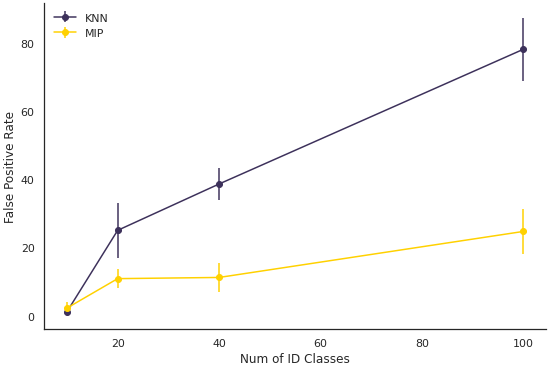

In [16]:

cmap3 = ["#3D315B", "#8189B1", "#708B75", "#9AB87A", "#D2D50B", "#FFD100" ]
# plt.style.use('ggplot')

with sns.axes_style("white"):
    sns.set_context("notebook")
    fig, (ax1) = plt.subplots(1, 1, figsize = (9, 6))

    ax1.set_xlabel("Num of ID Classes")
    ax1.set_ylabel("False Positive Rate")
    knn_fpr_mean, knn_fpr_std = get_mean_and_std([knn_fprs["sun"],knn_fprs["places365"],knn_fprs["dtd"],knn_fprs["inaturalist"]])
    mip_fpr_mean, mip_fpr_std = get_mean_and_std([mip_fprs["sun"],mip_fprs["places365"],mip_fprs["dtd"],mip_fprs["inaturalist"]])
    x = [10,20,40,100]
    print(knn_fpr_mean)
    print(knn_fpr_std)
    # ax1.set_xlim(-0.05, 4.05)
    #ax1.set_ylim(2, 8)
    ax1.errorbar(x,knn_fpr_mean, knn_fpr_std, fmt = "-o", label = "KNN", color = cmap3[0])
    ax1.errorbar(x,mip_fpr_mean, mip_fpr_std, fmt = "-o",label = "MIP", color = cmap3[5])
    ax1.spines[['top', 'right']].set_visible(False)
    # ax1.set_title("FPR95 Comparison")
    ax1.legend(loc = 'upper left')
    
    fig.savefig("fpr.pdf", bbox_inches = 'tight',pad_inches = 0)
    

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

# num_cls = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
num_cls = [100, 200, 400, 600, 800, 1000]
# num_cls = [100, 500]
mean_list = []
var_list = []
trials = 5

for c in num_cls:
    df_list = []
    for exp_num in range(trials):
        # c_str = '' if c == 1000 else str(c)
        data_temp = {}
        name = f'imagenet-subset-exp{exp_num}'
        class_list_loc = f'./results/ImageNet{str(c)}/MIP/CLIP_ViT-L/14_T_0.1_ID_{name}_normalize_False/{name}.csv'
        if not os.path.exists(class_list_loc):
            print('did not find', c, exp_num)
            exit = os.system(f'python eval_ood_detection.py --score="MIP" --CLIP_ckpt="ViT-L/14" --gpu=4 --server="galaxy-01" --in_dataset="ImageNet-subset" --model="CLIP" --feat_dim=768 --batch-size=250 --T=0.1 --num_imagenet_cls={c} --name=imagenet-subset-exp{exp_num} --seed={exp_num}')
            if (exit > 0): quit()
        df = pd.read_csv(class_list_loc, index_col=0)
        df_list.append(df)
    df = pd.concat(df_list, keys=list(range(trials)), names=['trials', 'dataset'])
    var = df.groupby(level=1).std()
    mean = df.groupby(level=1).mean()
    var_list.append(var)
    mean_list.append(mean)

mean_df = pd.concat(mean_list, keys=num_cls, names=['num_cls'])
var_df = pd.concat(var_list, keys=num_cls, names=['num_cls'])
stats = mean_df.axes[1]
datasets = mean_df.index.levels[1]
print(var_df.head())


                         FPR95     AUROC      AUPR
num_cls dataset                                   
100     AVG           7.476384  0.887344  0.881692
        SUN          10.082652  1.159849  1.346336
        dtd           3.862040  0.684010  0.770240
        iNaturalist   7.637674  0.929231  0.979474
        places365     9.363329  1.220012  1.370595


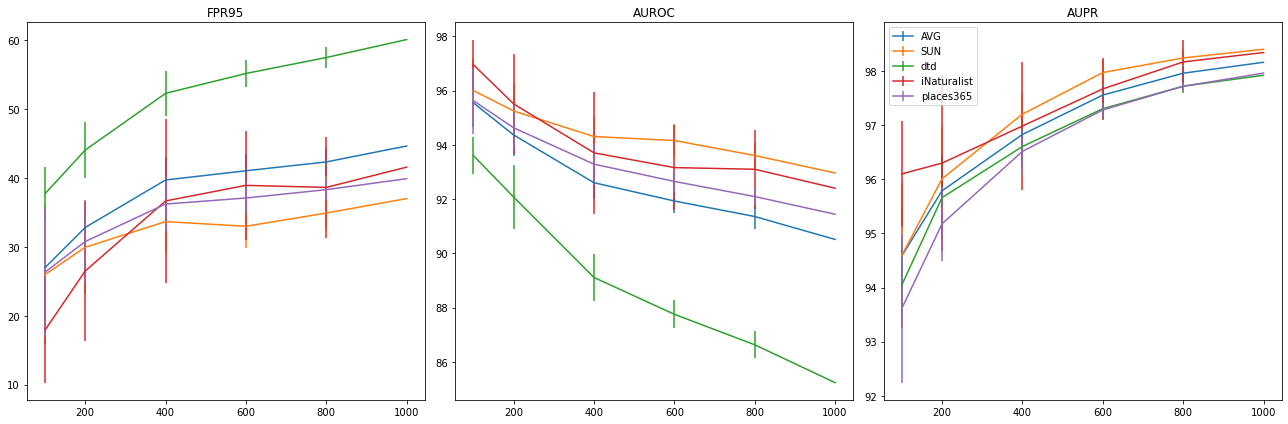

In [32]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(18, 6)
for i, score in enumerate(stats):
    for dataset in datasets:
        mean = mean_df.loc[(slice(None), dataset), score].values
        var = var_df.loc[(slice(None), dataset), score].values
        axs[i].errorbar(num_cls, mean, yerr=var, label=dataset)
        axs[i].set_title(score)
plt.legend()
plt.tight_layout()
plt.savefig('plots/imagenet_subset.png')


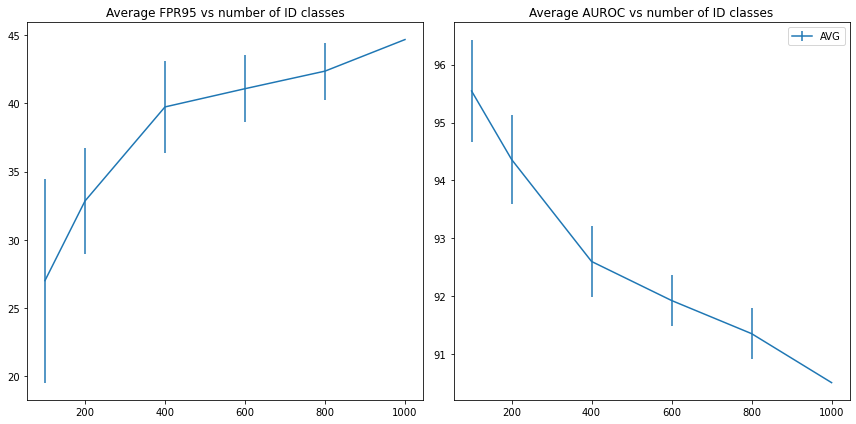

In [33]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 6)
dataset = 'AVG'
for i, score in enumerate(['FPR95', 'AUROC']):
    mean = mean_df.loc[(slice(None), dataset), score].values
    var = var_df.loc[(slice(None), dataset), score].values
    axs[i].errorbar(num_cls, mean, yerr=var, label=dataset)
    axs[i].set_title(f'Average {score} vs number of ID classes')
plt.legend()
plt.tight_layout()
plt.savefig('plots/AVG_FPR95_and_AUROC_vs_n_cls.png')


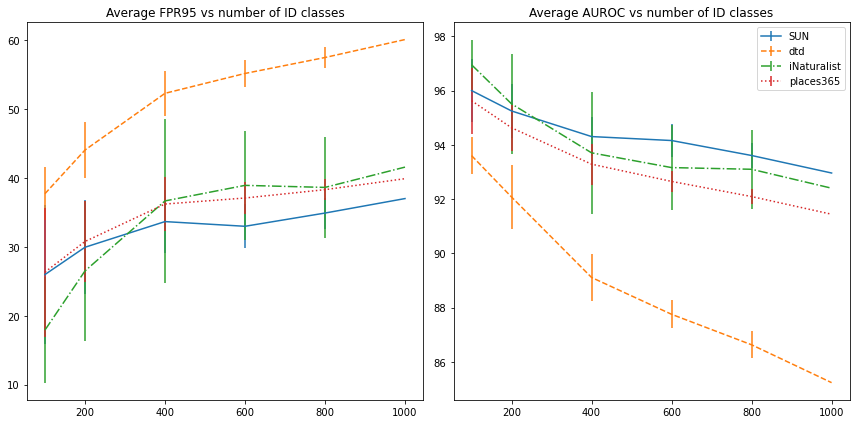

In [35]:
line_styles = ['-', '--', '-.', ':']
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 6)
for i, score in enumerate(['FPR95', 'AUROC']):
    for j, dataset in enumerate(datasets.drop('AVG')):
        mean = mean_df.loc[(slice(None), dataset), score].values
        var = var_df.loc[(slice(None), dataset), score].values
        axs[i].errorbar(num_cls, mean, yerr=var, label=dataset, linestyle=line_styles[j])
        axs[i].set_title(f'Average {score} vs number of ID classes')
plt.legend()
plt.tight_layout()
plt.savefig('plots/all_dataset_FPR95_and_AUROC_vs_n_cls.png')

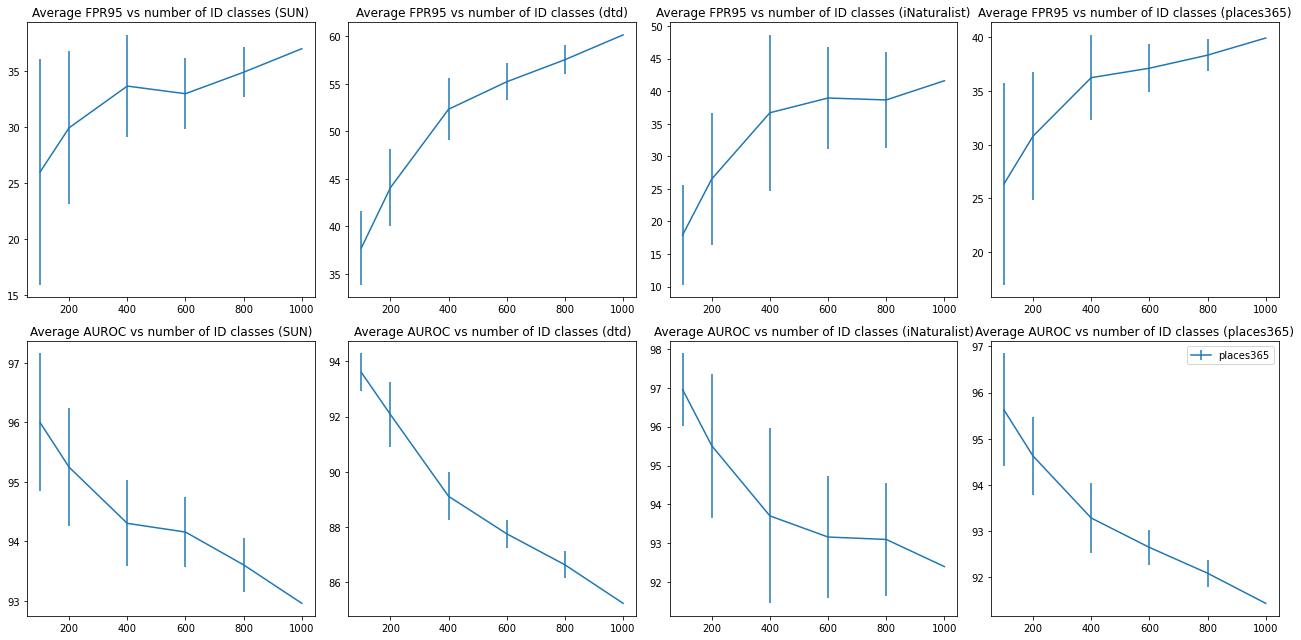

In [29]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(18, 9)
for i, score in enumerate(['FPR95', 'AUROC']):
    for j, dataset in enumerate(datasets.drop('AVG')):
        mean = mean_df.loc[(slice(None), dataset), score].values
        var = var_df.loc[(slice(None), dataset), score].values
        axs[i][j].errorbar(num_cls, mean, yerr=var, label=dataset)
        axs[i][j].set_title(f'Average {score} vs number of ID classes ({dataset})')
plt.legend()
plt.tight_layout()
plt.savefig('plots/per_dataset_FPR95_and_AUROC_vs_n_cls.png')